In [1]:
!pip install seaborn
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Initialize TPU if available, otherwise use CPU or GPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()  # Default strategy for CPU and single GPU
print("REPLICAS: ", strategy.num_replicas_in_sync)

from sklearn.model_selection import train_test_split

# Load data
(x_train_full, y_train_full), (x_test_full, y_test_full) = cifar10.load_data()
x_train_full, x_test_full = x_train_full / 255.0, x_test_full / 255.0

# Reduce the dataset size
x_train_full, x_test_full = x_train_full[:10000], x_test_full[:2000]
y_train_full, y_test_full = y_train_full[:10000], y_test_full[:2000]

# Split the training data into training, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(x_train_full, y_train_full, test_size=0.4, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# Define mappings for categorical genes
optimizer_mapping = {0: 'adam', 1: 'sgd', 2: 'rmsprop', 3: 'adagrad'}
activation_mapping = {0: 'relu', 1: 'tanh', 2: 'elu'}
batch_size_mapping = {0: 32, 1: 64, 2: 128}
kernel_size_mapping = {0: (3, 3), 1: (5, 5)}

# Function to generate a random individual (model configuration)
def generate_individual():
    # Each individual is a list of genes representing hyperparameters
    individual = [
        np.random.randint(2, 6),  # num_conv_layers
        np.random.randint(32, 257),  # num_filters
        np.random.uniform(0.2, 0.7),  # dropout_rate
        np.random.randint(0, 4),  # optimizer
        np.random.uniform(1e-6, 1e-2),  # learning_rate
        np.random.randint(0, 3),  # activation_function
        np.random.randint(15, 51),  # epochs
        np.random.randint(0, 3),  # batch_size
        np.random.randint(0, 2),  # kernel_size
        np.random.uniform(1e-5, 1e-1)  # regularization_lambda
    ]
    return individual

# Function to create a model based on an individual's genes
def create_model(ind):
    with strategy.scope():
        model = tf.keras.models.Sequential()
        reg_lambda = ind[9]

        # Add convolutional layers based on the individual's genes
        for i in range(int(ind[0])):
            if i == 0:
                # First layer needs to specify input_shape
                model.add(tf.keras.layers.Conv2D(int(ind[1]), kernel_size_mapping[int(ind[8])], activation=activation_mapping[int(ind[5])], padding='same', input_shape=(32, 32, 3), kernel_regularizer=l2(reg_lambda)))
            else:
                model.add(tf.keras.layers.Conv2D(int(ind[1]), kernel_size_mapping[int(ind[8])], activation=activation_mapping[int(ind[5])], padding='same', kernel_regularizer=l2(reg_lambda)))
            model.add(tf.keras.layers.MaxPooling2D((2, 2)))

        # Flatten and add dense layers
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(64, activation=activation_mapping[int(ind[5])], kernel_regularizer=l2(reg_lambda)))
        model.add(tf.keras.layers.Dropout(ind[2]))
        model.add(tf.keras.layers.Dense(10, activation='softmax'))

        # Compile model with categorical crossentropy for a multi-class classification problem
        model.compile(optimizer=optimizer_mapping[int(ind[3])],
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

    return model

# Fitness function to evaluate an individual's performance
def fitness_function(ind):
    model = create_model(ind)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

    # Lists to store test losses and accuracies for each epoch
    test_losses = []
    test_accuracies = []

    # Lists to accumulate training and validation losses and accuracies
    all_train_losses = []
    all_train_accuracies = []
    all_val_losses = []
    all_val_accuracies = []

    # Train the model for a number of epochs specified by the individual's genes
    for epoch in range(int(ind[6])):
        # Fit the model for one epoch and get the history
        history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=1, batch_size=batch_size_mapping[int(ind[7])], verbose=0, callbacks=[early_stopping, model_checkpoint])
        
        # Append the history values to the accumulating lists
        all_train_losses.extend(history.history['loss'])
        all_train_accuracies.extend(history.history['accuracy'])
        all_val_losses.extend(history.history['val_loss'])
        all_val_accuracies.extend(history.history['val_accuracy'])

        # Evaluate the model on the test set and append the results to the lists
        test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

    # Combine the accumulated history values into a dictionary
    combined_history = {
        'loss': all_train_losses,
        'accuracy': all_train_accuracies,
        'val_loss': all_val_losses,
        'val_accuracy': all_val_accuracies
    }

    # Evaluate the model's final performance on the test set
    score = model.evaluate(x_test, y_test, verbose=0)
    return score[1], combined_history, test_losses, test_accuracies

# Function to select an individual from a group using roulette wheel selection
def roulette_wheel_selection(group, fitnesses):
    total_fitness = sum(fitnesses)
    selection_probs = [f/total_fitness for f in fitnesses]
    selected_index = np.random.choice(len(group), p=selection_probs)
    return group[selected_index]

# Function to perform crossover between two parents
def crossover(parent1, parent2):
    child = []
    for gene1, gene2 in zip(parent1, parent2):
        # With 50% probability, choose gene from parent1, otherwise from parent2
        if np.random.rand() < 0.5:
            child.append(gene1)
        else:
            child.append(gene2)
    return child

# Function to mutate an individual
def mutate(child):
    mutation_rate = 0.1  # Set mutation rate
    for i in range(len(child)):
        # With probability equal to mutation_rate, mutate the gene
        if np.random.rand() < mutation_rate:
            if i in [3, 5, 7, 8]:  # These genes are categorical, so choose a random category
                child[i] = np.random.randint(0, 3)
            else:  # These genes are continuous, so sample a random value in the appropriate range
                child[i] = np.random.uniform(low=[2, 32, 0.2, 0, 1e-6, 0, 15, 0, 0, 1e-5][i], high=[5, 256, 0.7, 3, 1e-2, 2, 50, 2, 1, 1e-1][i])
    return child

# Function to perform migration between groups
def migration(groups):
    # Randomly select two groups
    idx1, idx2 = np.random.choice(len(groups), 2, replace=False)

    # Get the selected groups
    group1 = groups[idx1]
    group2 = groups[idx2]

    # Randomly select an individual from each group
    migrant_idx_from_group1 = np.random.choice(len(group1))
    migrant_idx_from_group2 = np.random.choice(len(group2))

    # Get the selected individuals
    migrant_from_group1 = group1[migrant_idx_from_group1]
    migrant_from_group2 = group2[migrant_idx_from_group2]

    # Swap the selected individuals between the two groups
    group1[migrant_idx_from_group1] = migrant_from_group2
    group2[migrant_idx_from_group2] = migrant_from_group1

# Function to perform colonization between groups
def colonization(groups):
    # Calculate the average fitness of each group
    group_fitnesses = [np.mean([fitness_function(ind)[0] for ind in group]) for group in groups]

    # Identify the best and worst groups
    best_group = groups[np.argmax(group_fitnesses)]
    worst_group = groups[np.argmin(group_fitnesses)]

    # Colonization: The best group sends half of its individuals to replace individuals in the worst group
    num_colonizers = len(best_group) // 2
    colonizers = best_group[:num_colonizers]
    worst_group = worst_group[num_colonizers:]
    worst_group.extend(colonizers)

# Main genetic algorithm function
def genetic_algorithm(pop_size, num_generations, num_mates, num_groups=2):
    # Initialize population with random individuals
    population = [generate_individual() for _ in range(pop_size)]

    # Divide the population into groups
    groups = [population[i::num_groups] for i in range(num_groups)]

    best_individual = None
    best_fitness = -1
    best_history = None

    # Main loop over generations
    for generation in range(num_generations):
        for group in groups:
            # Evaluate the fitness of each individual in the group
            fitnesses = []
            histories = []
            for ind in group:
                fitness, history, _, _ = fitness_function(ind)  # Unpack the returned values, but only use fitness and history
                fitnesses.append(fitness)
                histories.append(history)

            # Within-group dynamics: selection, crossover, and mutation
            parent1 = roulette_wheel_selection(group, fitnesses)
            parent2 = roulette_wheel_selection(group, fitnesses)
            while np.array_equal(parent1, parent2):  # Ensure two distinct parents are selected
                parent2 = roulette_wheel_selection(group, fitnesses)

            child = crossover(parent1, parent2)
            child = mutate(child)

            # Replace the worst individual in the group with the child
            min_fitness_index = np.argmin(fitnesses)
            group[min_fitness_index] = child

        # Between-group dynamics: migration and colonization
        migration(groups)
        colonization(groups)

        # Find the best individual in the current generation
        max_fitness_index = np.argmax(fitnesses)
        max_fitness = fitnesses[max_fitness_index]
        if max_fitness > best_fitness:
            best_fitness = max_fitness
            best_individual = population[max_fitness_index]
            _, best_history, best_test_losses, best_test_accuracies = fitness_function(best_individual) 

        print(f"Generation {generation+1}, Max Fitness: {max_fitness}")
    
    return best_individual, best_fitness, best_history, best_test_losses, best_test_accuracies

# Run the genetic algorithm with specified parameters
start_time = time.time()
best_individual, best_fitness, best_history, best_test_losses, best_test_accuracies = genetic_algorithm(pop_size=10, num_generations=3, num_mates=4)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 5.2 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


D1013 09:30:55.508027276      15 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D1013 09:30:55.508057818      15 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D1013 09:30:55.508061848      15 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D1013 09:30:55.508064848      15 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D1013 09:30:55.508067528      15 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D1013 09:30:55.508070576      15 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D1013 09:30:55.508073208      15 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D1013 09:30:55.

Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


REPLICAS:  8
170498071/170498071 [==============================] - 3s 0us/step


2023-10-13 09:31:23.060610: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-13 09:31:23.176257: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-13 09:31:27.534076: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-13 09:31:27.628327: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-13 09:34:12.655186: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-13 09:34:12.759227: E tensorflow/core/grappler/optimizers/meta

Generation 1, Max Fitness: 0.42500001192092896


2023-10-13 10:08:11.933925: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-13 10:08:12.040815: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-13 10:08:16.493836: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-13 10:08:16.637472: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-13 10:11:01.738927: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-13 10:11:01.859790: E tensorflow/core/grappler/optimizers/meta

Generation 2, Max Fitness: 0.37049999833106995


2023-10-13 10:43:11.360656: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-13 10:43:11.474223: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-13 10:43:15.521283: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-13 10:43:15.620339: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-13 10:46:00.268513: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-13 10:46:00.381721: E tensorflow/core/grappler/optimizers/meta

Generation 3, Max Fitness: 0.49149999022483826


In [2]:
# Display the best individual and fitness
param_names = [
    'num_conv_layers',
    'num_filters',
    'dropout_rate',
    'optimizer',
    'learning_rate',
    'activation',
    'epochs',
    'batch_size',
    'kernel_size',
    'reg_lambda'
]

print("Best fitness: ", best_fitness)

print("Best individual: ")
for i, param_name in enumerate(param_names):
    if i == 3:  # optimizer
        print(f"{param_name}: {optimizer_mapping[int(best_individual[i])]}")
    elif i == 5:  # activation
        print(f"{param_name}: {activation_mapping[int(best_individual[i])]}")
    elif i == 7:  # batch_size
        print(f"{param_name}: {batch_size_mapping[int(best_individual[i])]}")
    elif i == 8:  # kernel_size
        print(f"{param_name}: {kernel_size_mapping[int(best_individual[i])]}")
    elif i in [0, 1, 6]:  # num_conv_layers, num_filters, epochs
        print(f"{param_name}: {int(best_individual[i])}")
    else:
        print(f"{param_name}: {best_individual[i]}")


Best fitness:  0.49149999022483826
Best individual: 
num_conv_layers: 3
num_filters: 76
dropout_rate: 0.3747429346811466
optimizer: adagrad
learning_rate: 0.0030987721030272864
activation: tanh
epochs: 50
batch_size: 64
kernel_size: (3, 3)
reg_lambda: 0.01662710055251351


In [3]:
end_time = time.time()
total_time = end_time - start_time
print(f"Total computational time taken by the algorithm: {total_time:.2f} seconds")

Total computational time taken by the algorithm: 6666.35 seconds


In [4]:
# Load the best model directly
best_model = tf.keras.models.load_model('best_model.h5')

score = best_model.evaluate(x_test, y_test, verbose=0)

print(f"Test Loss: {score[0]}")
print(f"Test Accuracy: {score[1]}")

Test Loss: 3.879650354385376
Test Accuracy: 0.3779999911785126


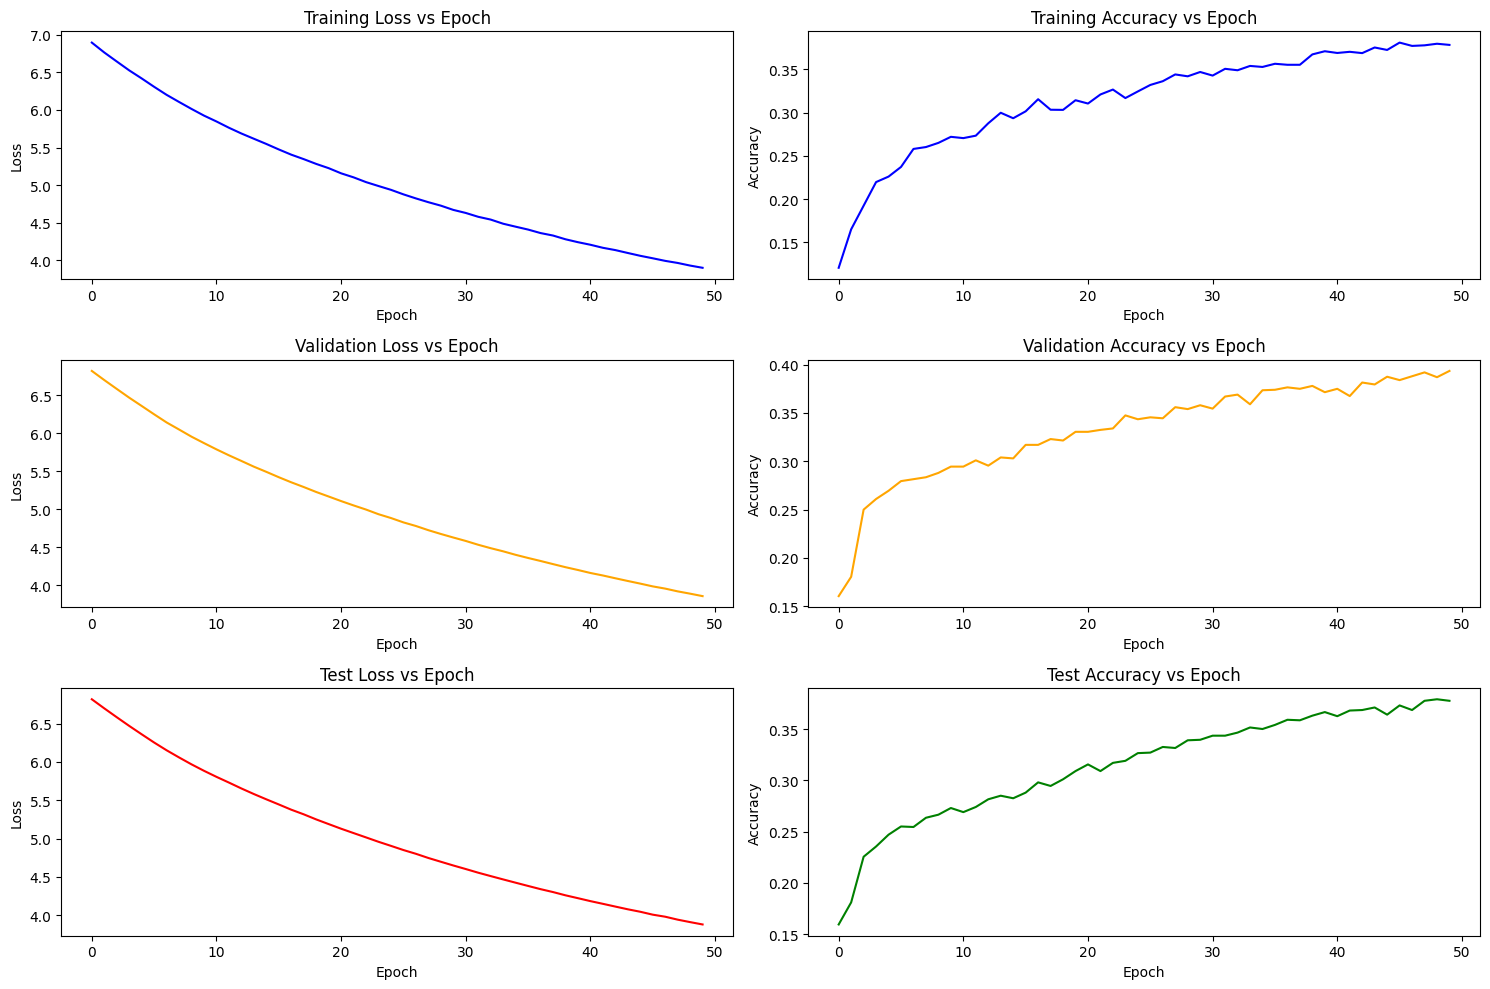

In [5]:
plt.figure(figsize=(15, 10))

# Plot for Training Loss vs Epoch
plt.subplot(3, 2, 1)
plt.plot(best_history['loss'], label='Training Loss', color='blue')
plt.title('Training Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot for Training Accuracy vs Epoch
plt.subplot(3, 2, 2)
plt.plot(best_history['accuracy'], label='Training Accuracy', color='blue')
plt.title('Training Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot for Validation Loss vs Epoch
plt.subplot(3, 2, 3)
plt.plot(best_history['val_loss'], label='Validation Loss', color='orange')
plt.title('Validation Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot for Validation Accuracy vs Epoch
plt.subplot(3, 2, 4)
plt.plot(best_history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Validation Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot for Test Loss vs Epoch
plt.subplot(3, 2, 5)
plt.plot(best_test_losses, label='Test Loss', color='red')
plt.title('Test Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot for Test Accuracy vs Epoch
plt.subplot(3, 2, 6)
plt.plot(best_test_accuracies, label='Test Accuracy', color='green')
plt.title('Test Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()


63/63 [==============================] - 1s 6ms/step


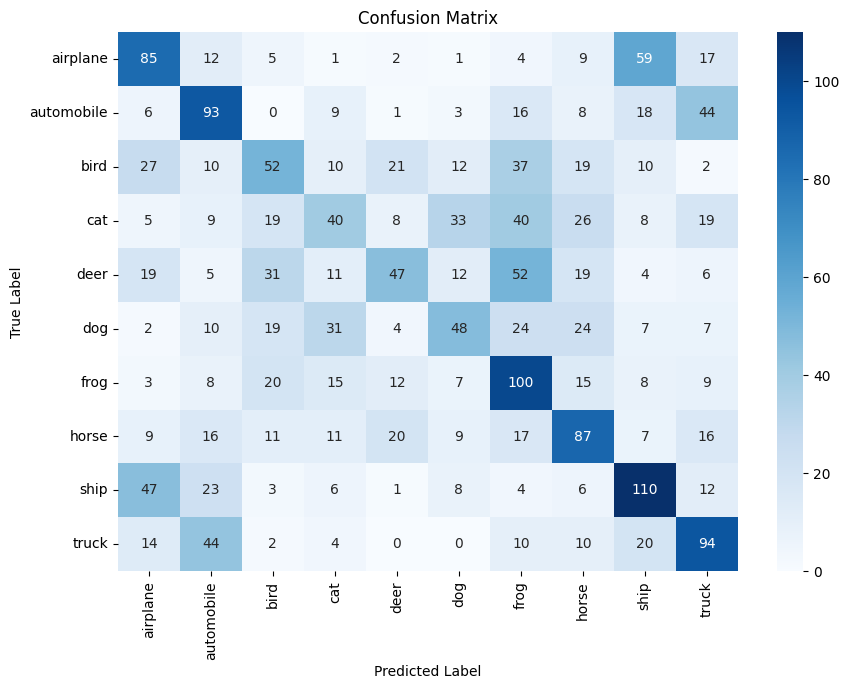

In [6]:
# Class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Get model predictions
y_pred_probabilities = best_model.predict(x_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred_probabilities, axis=1) 

# Convert validation observations to one hot vectors
y_true = y_test.squeeze()

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [7]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Calculate precision, recall, and f1-score for each class
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print(report)

# If you want to access precision, recall, and f1-score values separately, you can do it as follows:
precision_recall_f1 = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=True)

# Extract precision, recall, and f1-score for each class
for class_name in class_names:
    precision = precision_recall_f1[class_name]['precision']
    recall = precision_recall_f1[class_name]['recall']
    f1_score = precision_recall_f1[class_name]['f1-score']
    print(f"For class {class_name}:")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1_score:.2f}")
    print("---")

              precision    recall  f1-score   support

    airplane       0.39      0.44      0.41       195
  automobile       0.40      0.47      0.43       198
        bird       0.32      0.26      0.29       200
         cat       0.29      0.19      0.23       207
        deer       0.41      0.23      0.29       206
         dog       0.36      0.27      0.31       176
        frog       0.33      0.51      0.40       197
       horse       0.39      0.43      0.41       203
        ship       0.44      0.50      0.47       220
       truck       0.42      0.47      0.44       198

    accuracy                           0.38      2000
   macro avg       0.37      0.38      0.37      2000
weighted avg       0.38      0.38      0.37      2000

For class airplane:
Precision: 0.39
Recall: 0.44
F1-score: 0.41
---
For class automobile:
Precision: 0.40
Recall: 0.47
F1-score: 0.43
---
For class bird:
Precision: 0.32
Recall: 0.26
F1-score: 0.29
---
For class cat:
Precision: 0.29
Recall: 